In [12]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import ast
import trimesh
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation 

from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    HardPhongShader, OpenGLOrthographicCameras, PointsRasterizationSettings,
    PointsRasterizer, NormWeightedCompositor, DirectionalLights)
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes

notebook_path = os.path.abspath("../")
os.chdir(notebook_path)
from mvtorch.view_selector import MVTN
from mvtorch.mvrenderer import MVRenderer
from mvtorch.utils import torch_color, torch_center_and_normalize
from utils_mvtn import write_obj_with_color, save_colored_obj_with_faces, calculer_aires_triangles_batch
from mvtorch.data import ScanObjectNN, CustomDataLoader, ModelNet40, rotation_matrix

In [2]:
nb_views = 12
views_config = "circular"
bs = 1
data_dir = "/home/mpelissi/Dataset/ModelNet40/"
category = "all"
simplified_mesh = True

# Global parameters
points_per_pixel=1; points_radius=0.02; image_size=224

In [ ]:
# Model 3D remeshing iso
dir_remeshing =  "/home/mpelissi/Dataset/ModelNet40_remeshing_iso"
dir_output = "/home/mpelissi/MVTN/my_MVTN/outputs"
all_mesh_iso = glob.glob(os.path.join(dir_remeshing, "*/*/*.obj")); print(f"🔎​​​ Number of meshes found in {dir_remeshing} : {len(all_mesh_iso)}")
# Data loading
dset_train = ModelNet40(data_dir=data_dir, split='train', samples_per_class=None, category=category, simplified_mesh=simplified_mesh)
dset_test = ModelNet40(data_dir=data_dir, split='test', samples_per_class=None, category=category, simplified_mesh=simplified_mesh)
train_loader = CustomDataLoader(dset_train, batch_size=bs, shuffle=True, drop_last=False, pin_memory=True)
test_loader = CustomDataLoader(dset_test, batch_size=bs, shuffle=False, drop_last=False, pin_memory=True)
print(f"🔎​​​ Which categories are used ? 🚨​ {category} 🚨​\n")

🔎​​​ Number of meshes found in /home/mpelissi/Dataset/ModelNet40_remeshing_iso : 12311
🔎​​​ Which categories are used ? 🚨​ all 🚨​



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');  print("💻 device : ", device)
mvtn = MVTN(nb_views, views_config).cuda()
mvrenderer = MVRenderer(nb_views=nb_views, return_mapping=False, pc_rendering=False).cuda()

💻 device :  cuda


## Reference

Azimuth: tensor([[-270., -240., -210., -180., -150., -120.,  -90.,  -60.,  -30.,    0.,
           30.,   60.]], device='cuda:0') 
Elevation: tensor([[30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.]],
       device='cuda:0') 
Distance: tensor([[2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000, 2.2000,
         2.2000, 2.2000, 2.2000]], device='cuda:0')


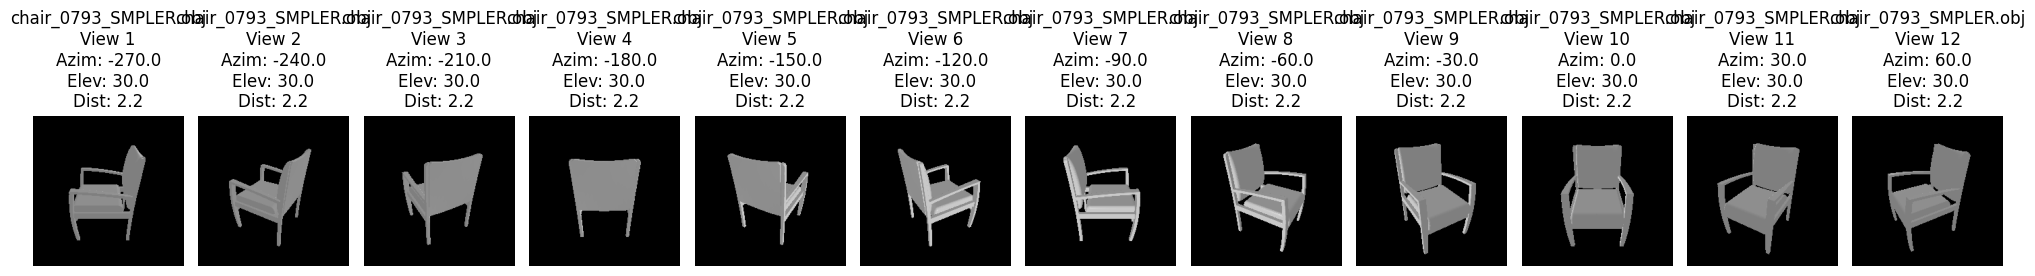

In [5]:
#for dset, loader in zip([dset_train, dset_test], [train_loader, test_loader]):
dset = dset_train; loader = train_loader
#dset = dset_test; loader = test_loader
for i, (targets, ref_mesh, points, names) in enumerate(loader):   
    # reference mesh   
    azim, elev, dist = mvtn(points, c_batch_size=len(targets))
    print("Azimuth:", azim, "\nElevation:", elev, "\nDistance:", dist)
    ref_images, _ = mvrenderer(ref_mesh, points, azim=azim, elev=elev, dist=dist)
    if i == 0:        break


fig, axes = plt.subplots(bs, nb_views, figsize=(20, 8))
for i in range(bs):
    # Iterate through 6 of the 12 views for each object
    for j in range(nb_views):
        ax = axes[j]
        # Get image from rendered_images and move to CPU, take first 3 channels
        img = ref_images[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{os.path.basename(names[i])}\nView {j+1}\nAzim: {azim[i,j]:.1f}\nElev: {elev[i,j]:.1f}\nDist: {dist[i,j]:.1f}')

plt.tight_layout()

# Pour 1 obj


In [6]:
path_mesh_modelnet40 = names[0]; print(f"🔎​​​ Path to the reference mesh : {path_mesh_modelnet40}")
path_mesh_iso = [p for p in all_mesh_iso if os.path.basename(path_mesh_modelnet40).split('_SM')[0] in p][0]
cat = path_mesh_iso.split('/')[-3]; type = path_mesh_iso.split('/')[-2]; name = path_mesh_iso.split('/')[-1].split('.')[0]
print(cat, type, name)

🔎​​​ Path to the reference mesh : /home/mpelissi/Dataset/ModelNet40//chair/train/chair_0793_SMPLER.obj
chair train chair_0793_SMPLER_centered_scaled_remeshing_iso_iter5


## Transformation as in the dataset

In [7]:
# load mesh from remeshing iso
print(f"🔎​​​ Loading mesh from {os.path.join(dir_remeshing, cat, type, name + '.obj')}")
mesh_iso = trimesh.load(os.path.join(dir_remeshing, cat, type, name + ".obj"), force='mesh')        
if not dset.is_rotated:
    angle = dset.initial_angle; rot_axis = [1, 0, 0]
else :
    angle = rotations_list[index]["rot_theta"][0]
    rot_axis = [dset.rotations_list[index]["rot_x"][0], dset.rotations_list[index]["rot_y"][0], dset.rotations_list[index]["rot_z"][0]]

verts = np.array(mesh_iso.vertices.data.tolist())
faces = np.array(mesh_iso.faces.data.tolist())
if dset.cleaned_mesh:
     if dset.correction_factors[index] == -1 and dset.simplified_mesh: # flip the faces 
        faces[:,0] , faces[:,2] = faces[:,2] , faces[:,0]

verts = rotation_matrix(rot_axis, angle).dot(verts.T).T
verts = torch_center_and_normalize(torch.from_numpy(verts).to(torch.float), p=dset.dset_norm); nb_verts = verts.shape[0]
faces = torch.from_numpy(faces); nb_faces = faces.shape[0]; 
array_faces = faces.cpu().numpy() 
array_normals = mesh_iso.vertex_normals
normals = torch.tensor(array_normals, dtype=torch.float32).cuda()
print(f"🔎​​​ Number of vertices : {nb_verts}, number of faces : {nb_faces}")

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb)
mesh = Meshes(verts=[verts],faces=[faces],textures=textures)

🔎​​​ Loading mesh from /home/mpelissi/Dataset/ModelNet40_remeshing_iso/chair/train/chair_0793_SMPLER_centered_scaled_remeshing_iso_iter5.obj
🔎​​​ Number of vertices : 16095, number of faces : 32284


/tmp/ipykernel_3000496/471179033.py:21: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  normals = torch.tensor(array_normals, dtype=torch.float32).cuda()


Projections dans les N vues

In [8]:
background_color = torch_color(mvrenderer.background_color, mvrenderer.background_color, max_lightness=True,).cuda()
color = mvrenderer.rendering_color(None)

if not mvrenderer.pc_rendering: # Mesh rendering
    lights = DirectionalLights(device=background_color.device, direction=mvrenderer.light_direction(azim, elev, dist))
    rendered_images, cameras, _, mesh_world, R, T, renderer = mvrenderer.render_meshes(meshes=mesh, color=color, azim=azim, elev=elev, dist=dist, lights=lights, background_color=background_color, projection = True)
    
# transform xyz to the camera view coordinates
cam_points = cameras.get_world_to_view_transform().transform_points(mesh_world.verts_list()[0].unsqueeze(0))
cam_points_np = cam_points.cpu().numpy()
# transform xyz to the camera view coordinates
cam_normals = cameras.get_world_to_view_transform().transform_normals(normals.unsqueeze(0))
cam_normals_np = cam_normals.cpu().numpy()
# Cartes de profondeur
fragments = renderer.rasterizer(mesh_world, cameras=cameras)
depthmaps_np = fragments.zbuf[:,:,:,0].cpu().numpy()

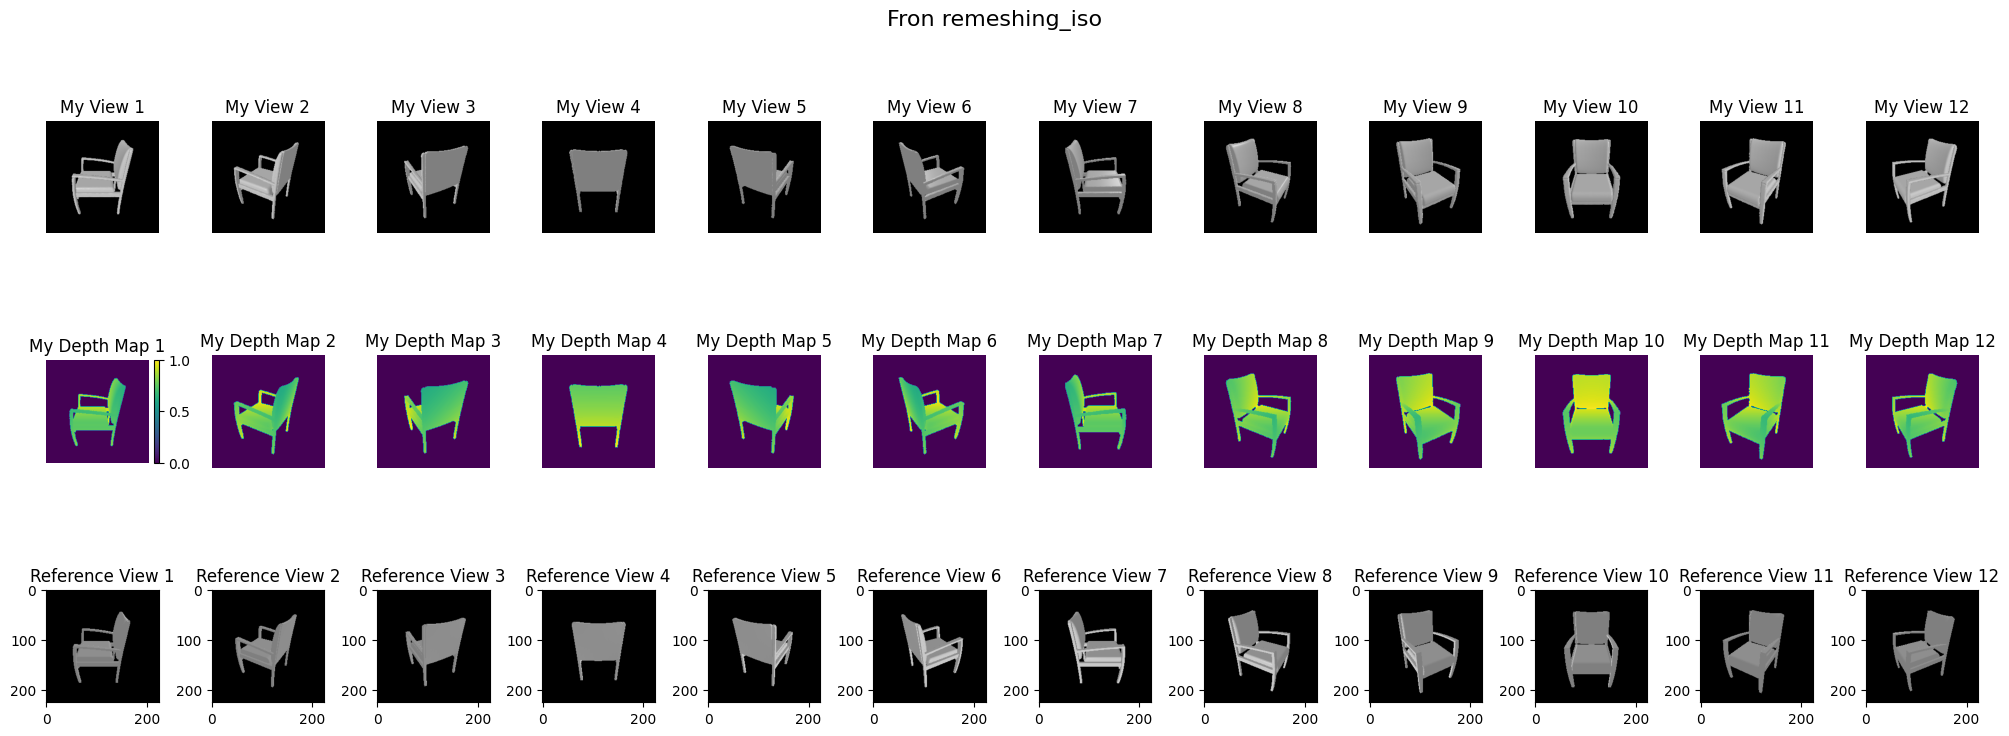

In [9]:
fig, axes = plt.subplots(3, nb_views, figsize=(20, 8))
fig.suptitle("Fron remeshing_iso", fontsize=16)
for i in range(bs):
    for j in range(nb_views):
        # Get image from rendered_images and move to CPU, take first 3 channels
        img = rendered_images[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        axes[0,j].imshow(img); axes[0,j].axis('off')
        axes[0,j].set_title(f'My View {j+1}')
        axes[1,j].imshow(depthmaps_np[j], cmap='viridis'); axes[1,j].axis('off')     
        axes[1,j].set_title(f'My Depth Map {j+1}')
        if j == 0: cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
        img_ref = ref_images[i, j].cpu().detach().permute(1, 2, 0)[:, :, :3]
        axes[2,j].imshow(img_ref), ax.axis('off')
        axes[2,j].set_title(f'Reference View {j+1}')
plt.tight_layout()

In [10]:
# pix_to_face is of shape (N, H, W, 1)
pix_to_face = fragments.pix_to_face ; print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W, 1]
pix_to_face = fragments.pix_to_face[..., 0] ; print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W]
print("pix_to_face shape:", pix_to_face.shape)  # Expected: [N, H, W]

pix_to_face shape: torch.Size([12, 224, 224, 1])
pix_to_face shape: torch.Size([12, 224, 224])
pix_to_face shape: torch.Size([12, 224, 224])


In [14]:
visible_faces_per_view = []
visible_verts_per_view = []
#faces = world_mesh.faces_packed()  # (F, 3)

for b in tqdm(range(pix_to_face.shape[0])):
    array_pt_cloud_b = cam_points_np[b]
    array_normals_b = cam_normals_np[b]
    
    # 1. Get valid face indices (ignore -1 = background)
    face_ids = pix_to_face[b]
    idx_visible_faces_b = torch.unique(face_ids[face_ids >= 0]) % nb_faces  # remove -1 (background)
    idx_visible_faces_b_np = idx_visible_faces_b.cpu().numpy()
    visible_faces_per_view.append(idx_visible_faces_b)
    print(f"Visible faces for view {b}: {idx_visible_faces_b.shape}")  
    
    # 2. Extract visible vertices from those faces
    idx_visible_verts_b = torch.unique(torch.tensor(array_faces)[idx_visible_faces_b])
    idx_visible_verts_b_np = idx_visible_verts_b.cpu().numpy()
    visible_verts_per_view.append(idx_visible_verts_b)   
    print(f"Visible vertices for view {b}: {idx_visible_verts_b.shape}") 
    
    obj_filename = f"{os.path.join(dir_output, name)}_myview_{b+1}_color.obj"
    write_obj_with_color(array_pt_cloud_b, array_faces, idx_visible_verts_b_np, obj_filename)
    
    ## Angle sommets visibles
    cos_angle_visible_vertex_b = np.full(array_pt_cloud_b.shape[0], np.nan)
    # sommets et normales visibles
    v_visible = array_pt_cloud_b[idx_visible_verts_b_np]
    n_visible = array_normals_b[idx_visible_verts_b_np]
    n_norms = np.linalg.norm(n_visible, axis=1, keepdims=True)
    n_norms[np.where(n_norms == 0)] = 1e-10 # quelques normales sont nulles
    # normalisation
    n_visible_norm = n_visible / n_norms
    # vecteurs directeurs
    D = -v_visible
    D /= np.linalg.norm(D, axis=1, keepdims=True)
    cos_alpha = np.abs(np.sum(D * n_visible_norm, axis=1))
    cos_angle_visible_vertex_b[idx_visible_verts_b_np] = cos_alpha   
    obj_filename_angle = f"{os.path.join(dir_output, name)}_myview_{b+1}_angles.obj"
    save_colored_obj_with_faces(obj_filename_angle, array_pt_cloud_b, cos_angle_visible_vertex_b, array_faces)
    
    
    # Surface Totale 3D
    surface3D_b = np.sum(calculer_aires_triangles_batch(array_pt_cloud_b, array_faces))
    # Surface visible de la projection courante
    surface3D_visible_b = np.sum(calculer_aires_triangles_batch(array_pt_cloud_b, array_faces[idx_visible_faces_b_np]))
    
    #data_output_path = os.path.join(dir_output, cat, type, name+"_cam"+str(i+1)+"_data.npz")
    data_output_path = os.path.join(dir_output, name+"_cam"+str(b+1)+"_data.npz")

    # Step 1: Save all array data in a compressed .npz file
    # np.savez_compressed(
    #     data_output_path,
    #     array_pt_cloud = array_pt_cloud_b,
    #     array_normals = array_normal_b,
    #     dephtmap = depthmaps_np[b],
    #     visible_vertex_idx = idx_visible_verts_b_np,
    #     visible_faces = idx_visible_faces_b_np,
    #     cos_angles = cos_angle_visible_vertex_b,
    #     surface3D = surface3D_b,
    #     surface3D_visible = surface3D_visible_b)

  0%|          | 0/12 [00:00<?, ?it/s]

Visible faces for view 0: torch.Size([5541])
Visible vertices for view 0: torch.Size([4954])


  8%|▊         | 1/12 [00:00<00:04,  2.27it/s]

Visible faces for view 1: torch.Size([5951])
Visible vertices for view 1: torch.Size([5413])


 17%|█▋        | 2/12 [00:00<00:04,  2.08it/s]

Visible faces for view 2: torch.Size([5630])
Visible vertices for view 2: torch.Size([4052])


 25%|██▌       | 3/12 [00:01<00:04,  2.24it/s]

Visible faces for view 3: torch.Size([4356])
Visible vertices for view 3: torch.Size([2585])


 33%|███▎      | 4/12 [00:01<00:03,  2.21it/s]

Visible faces for view 4: torch.Size([5648])
Visible vertices for view 4: torch.Size([4042])


 42%|████▏     | 5/12 [00:02<00:03,  2.27it/s]

Visible faces for view 5: torch.Size([5994])
Visible vertices for view 5: torch.Size([5432])


 50%|█████     | 6/12 [00:02<00:02,  2.33it/s]

Visible faces for view 6: torch.Size([5535])
Visible vertices for view 6: torch.Size([4918])


 58%|█████▊    | 7/12 [00:03<00:02,  2.36it/s]

Visible faces for view 7: torch.Size([7308])
Visible vertices for view 7: torch.Size([5764])


 67%|██████▋   | 8/12 [00:03<00:01,  2.38it/s]

Visible faces for view 8: torch.Size([8087])
Visible vertices for view 8: torch.Size([6014])


 75%|███████▌  | 9/12 [00:03<00:01,  2.39it/s]

Visible faces for view 9: torch.Size([8181])
Visible vertices for view 9: torch.Size([5739])


 83%|████████▎ | 10/12 [00:04<00:00,  2.46it/s]

Visible faces for view 10: torch.Size([8049])
Visible vertices for view 10: torch.Size([5991])


 92%|█████████▏| 11/12 [00:04<00:00,  2.53it/s]

Visible faces for view 11: torch.Size([7282])
Visible vertices for view 11: torch.Size([5700])


100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


In [ ]:
np.max(idx_visible_faces_b_np)